# Trufl
> Optimizing adaptive sampling using Multiple-criteria decision-making

**Trufl** was initiated in the context of the [IAEA (International Atomic Energy Agency)](https://www.iaea.org) Coordinated Research Project (CRP) titled ["Monitoring and Predicting Radionuclide Uptake and Dynamics for Optimizing Remediation of Radioactive Contamination in Agriculture"](https://www.iaea.org/newscenter/news/new-crp-monitoring-and-predicting-radionuclide-uptake-and-dynamics-for-optimizing-remediation-of-radioactive-contamination-in-agriculture-crp-d15019).

While **Trufl** was originally developed to address the remediation of farmland affected by nuclear accidents, its approach and algorithms are **applicable to a wide range of application domains**. This includes managing **legacy contaminants** or monitoring phenomena that require consideration of multiple decision criteria over time, taking into account a wide range of factors and contexts.

This package leverages the work done by [Floris Abrams](https://www.linkedin.com/in/floris-abrams-59080a15a) in the context of his PhD in collaboration between [SCK CEN](https://www.sckcen.be) and [KU Leuven](https://www.kuleuven.be) and [Franck Albinet](https://www.linkedin.com/in/franckalbinet), International Consultant in Geospatial Data Science and currently PhD researcher in AI applied to nuclear remedation at [KU Leuven](https://www.kuleuven.be).


## Install

`pip install trufl`

## Getting started

In highly sensitive and high-stakes situations, it is **essential that decision making is informed, transparent, and accountable**, with decisions being based on a thorough and objective analysis of the available data and the needs and concerns of affected communities being taken into account.

Given the time constraints and limited budgets that are often associated with data surveys (in particular ones supposed to informed highly sensitive situation), it is **crucial to make informed decisions about how to allocate resources**. This is even more important when considering the many variables that can be taken into account, such as prior knowledge of the area, health and economic impacts, land use, whether remediation has already taken place, population density, and more. Our approach leverages **Multiple-criteria decision-making** approaches to optimize the data survey workflow:

In this demo, we will walk you through a **typical workflow** using the `Trufl` package. To help illustrate the process, we will use a "toy" dataset that represents a typical spatial pattern of soil contaminants.

1. We **assume that we have access to the ground truth**, which is a raster file that shows the spatial distribution of a soil contaminant;
2. We will make decisions about how to optimally sample the  **administrative units (polygons)**, which in this case are **simulated as a grid** (using the `gridder` utilities function);
3. Based on prior knowledge, such as prior airborne surveys or other data, an `Optimizer` will **rank each administrative unit (grid cell) according to its priority for sampling**;
4. We will then **perform random sampling on the designated units (grid cells)** (using a `Sampler`). To simulate the measurement process, we will use the ground truth to emulate measurements at each location (using a `DataCollector`);
5. We will **evaluate the new state of each unit based on the measurements** and **pass it to a new round of optimization**. This process will be repeated iteratively to refine the sampling strategy.

In [ ]:
#| hide
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd

from trufl.utils import gridder
from trufl.sampler import Sampler, rank_to_sample
from trufl.collector import DataCollector
from trufl.callbacks import (State, MaxCB, MinCB, StdCB, CountCB, MoranICB, PriorCB)
from trufl.optimizer import Optimizer


red, black = '#BF360C', '#263238'

### Our simulated ground truth

The assumed ground truth reveals a typical spatial pattern of contaminant such as `Cs137` after a nuclear accident for instance:

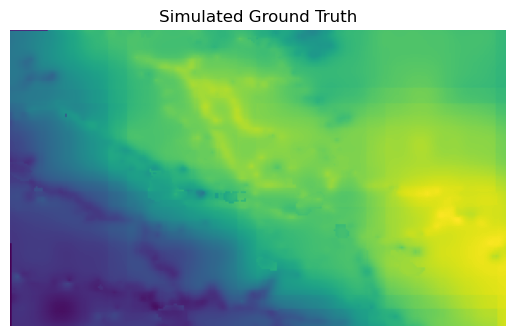

In [ ]:
fname_raster = './files/ground-truth-01-4326-simulated.tif'
with rasterio.open(fname_raster) as src:
    plt.axis('off')
    plt.imshow(src.read(1))
    plt.title('Simulated Ground Truth')

### Simulate administrative units

The sampling strategy will be determined on a per-grid-cell basis within the administrative unit. We define below a 10 x 10 grid over the area of interest:

In [ ]:
gdf_grid = gridder(fname_raster, nrows=10, ncols=10)
gdf_grid.head()

,geometry
loc_id,
0,"POLYGON ((-1.20830 43.26950, -1.20830 43.26042..."
1,"POLYGON ((-1.20830 43.27858, -1.20830 43.26950..."
2,"POLYGON ((-1.20830 43.28766, -1.20830 43.27858..."
3,"POLYGON ((-1.20830 43.29673, -1.20830 43.28766..."
4,"POLYGON ((-1.20830 43.30581, -1.20830 43.29673..."


:::{.callout-tip}

Note how each administrative unit is uniquely identified by its `loc_id`.

:::

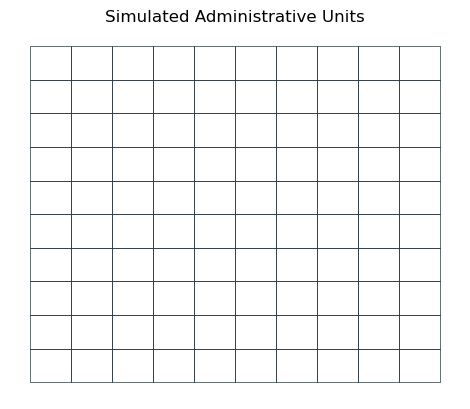

In [ ]:
gdf_grid.boundary.plot(color=black, lw=0.5)
plt.axis('off')
plt.title('Simulated Administrative Units');

### Round I: Optimize sampling based on prior at $t_0$

#### What prior knowledge do we have?

At the initial time $t_0$, data sampling has not yet begun, but we can often **leverage existing prior knowledge of our phenomenon** of interest to inform our sampling strategy/policy. In the context of nuclear remediation, this prior knowledge can often be obtained through mobile surveys, such as airborne or carborne surveys, which can provide a **coarse estimation** of soil contamination levels.

In the example below, we **simulate prior information** about the soil property of interest by **calculating the average value of the property over each grid cell**.

At this stage, we have no measurements, so we simply create an empty [Geopandas GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html). 

In [ ]:
samples_t0 = gpd.GeoDataFrame(index=pd.Index([], name='loc_id'), 
                              geometry=None, data={'value': None})

:::{.callout-tip}

We need to set an index `loc_id` and have a `geometry` and `value` columns.

:::

Now we get/"sense" the state of our grid cells based on the simulated prior (Mean over each grid cell `PriorCB`):

In [ ]:
state = State(samples_t0, gdf_grid, cbs=[PriorCB(fname_raster)])

# You have to call the instance
state_t0 = state(); state_t0.head()

,Prior
loc_id,
0,0.102492
1,0.125727
2,0.161802
3,0.184432
4,0.201405


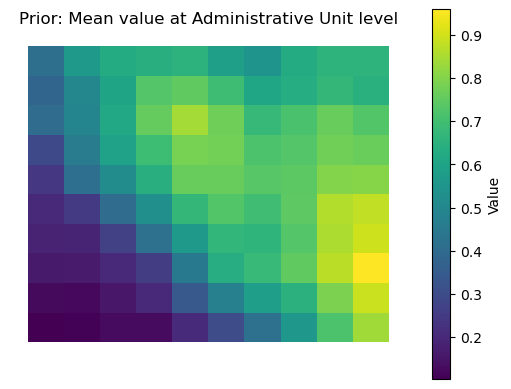

In [ ]:
gdf_grid.join(state_t0, how='left').plot(column='Prior',
                                         cmap='viridis', 
                                         legend_kwds={'label': 'Value'}, 
                                         legend=True)
plt.axis('off')
plt.title('Prior: Mean value at Administrative Unit level');

:::{.callout-tip}

We get the `Prior` for each individual `loc_id` (here only the first 5 shown). The current `State` is only composed of a single `PriorCB` variable but can include many more variables as we will see below. 

:::

#### Sampling priority ranks

In [ ]:
benefit_criteria = [True]
optimizer = Optimizer(state=state_t0)
df_rank = optimizer.get_rank(is_benefit_x=benefit_criteria, w_vector = [1],  
                             n_method=None, c_method = None, 
                             w_method=None, s_method="CP")

df_rank.head()

,rank
loc_id,
92,1
93,2
91,3
94,4
82,5


:::{.callout-tip}

For more information on how the `Optimizer` operates, please see the section [Delving deeper into the optimization process](#delving-deeper-into-the-optimization-process).


:::

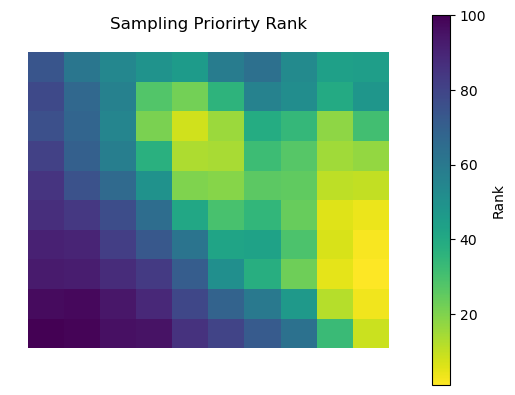

In [ ]:
gdf_grid.join(df_rank, how='left').plot(column='rank',
                                        cmap='viridis_r', 
                                        legend_kwds={'label': 'Rank'}, 
                                        legend=True)
plt.axis('off')
plt.title('Sampling Priorirty Rank');

#### Informed random sampling

:::{.callout-tip}

It's worth noting that in the absence of any prior knowledge, a uniform sampling strategy over the area of interest may be used. However, this approach may not be the most efficient use of the available data collection and analysis budget.

:::

Based on the **ranks (sampling priority)** calculated by the `Optimizer` and given sampling **budget**, let's calculate the number of samples to be collected for each administrative unit (`loc_id`). **Different sampling policies** can be used (Weighted, Quantiles, ...):

In [ ]:
budget_t0 = 600
n = rank_to_sample(df_rank['rank'].sort_index().values, 
                   budget=budget_t0, min=1, policy="quantiles"); n

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  4,  4,
        4,  4,  4,  1,  1,  1,  1,  1,  4,  4,  4,  4,  4,  1,  1,  1,  4,
        4,  7,  7, 12,  7,  7,  1,  1,  4,  4,  7, 12, 12, 12, 12,  7,  1,
        4,  4,  7,  7, 12, 12, 12,  7,  4,  4,  4,  7,  7,  7,  7,  7,  7,
        4,  4,  4,  7, 12,  7, 12, 12,  7,  7,  4,  4,  7, 12, 12, 12, 12,
       12, 12, 12,  7,  7, 12, 12, 12, 12, 12, 12, 12,  7,  7,  7])

We can now decide where to sample based on this sampling schema:

                         geometry
loc_id                           
0       POINT (-1.21199 43.26316)
1       POINT (-1.22130 43.27479)
2       POINT (-1.22253 43.27997)
3       POINT (-1.21955 43.29211)
4       POINT (-1.21886 43.30006)


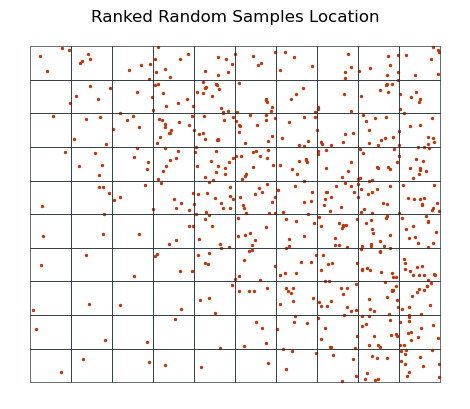

In [ ]:
sampler = Sampler(gdf_grid)
sample_locs_t0 = sampler.sample(n, method='uniform')

print(sample_locs_t0.head())
ax = sample_locs_t0.plot(markersize=2, color=red)

gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax)
plt.axis('off')
plt.title('Ranked Random Samples Location');

#### Emulating measurement campaign

The data collector collects measurements at the random sampling locations in the field. In our case, we emulate this process by extracting measurements from the provided raster file.

"Measuring" variable of interest from a given raster:

                         geometry     value
loc_id                                     
0       POINT (-1.21199 43.26316)  0.085935
1       POINT (-1.22130 43.27479)  0.214813
2       POINT (-1.22253 43.27997)  0.150502
3       POINT (-1.21955 43.29211)  0.185843
4       POINT (-1.21886 43.30006)  0.197671


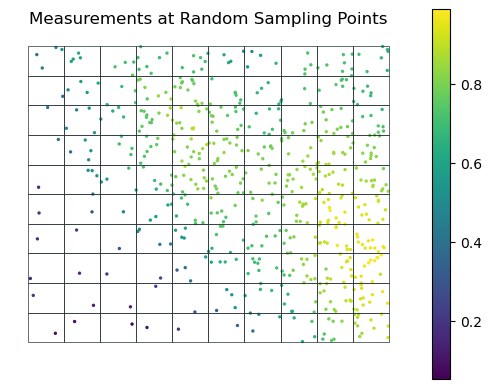

In [ ]:
dc_emulator = DataCollector(fname_raster)
measurements_t0 = dc_emulator.collect(sample_locs_t0)

print(measurements_t0.head())
ax = measurements_t0.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax);
plt.axis('off')
plt.title('Measurements at Random Sampling Points');

This marks the **end of our initial measurement efforts**, based on our prior knowledge of the phenomenon. **Going forward, we can use the additional insights gained during this phase** to enhance our future measurements.

### Round II: Optimize sampling with additional insights at $t_1$

For each administrative unit, we now have additional knowledge acquired during the previous campaign, in addition to our prior knowledge. **In the current round**, the **optimization** of the sampling will be **carried out based on** the **maximum**, **minimum**, **standard Deviation**, **number of measurements** already conducted, our **prior knowledge**, and an estimate of the **presence of spatial trends** or spatial correlations (Moran's I).

:::{.callout-tip}

It's worth noting that you can use any quantitative or qualitative secondary geographical information as a variable in the state, such as population, whether any previous remediation actions have taken place, the economic impact of the contamination, and so on.

:::

#### Getting administrative units new state

In [ ]:
state = State(measurements_t0, gdf_grid, cbs=[
    MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)])

In [ ]:
state().head()

,Max,Min,Standard Deviation,Count,Moran.I,Prior
loc_id,,,,,,
0,0.085935,0.085935,0.0,1,NaN,0.102492
1,0.214813,0.214813,0.0,1,NaN,0.125727
2,0.150502,0.150502,0.0,1,NaN,0.161802
3,0.185843,0.185843,0.0,1,NaN,0.184432
4,0.197671,0.197671,0.0,1,NaN,0.201405


:::{.callout-tip}

The **Moran's I index** is a statistical method used to determine if there is a **spatial correlation/trend** within each area of interest. For example, a **random field** would have a **Moran's I index close to 0**, while a clear **gradient of low to high values**, such as from south to north, would be characterized by a **Moran's I index close to 1**.

:::

#### Finding optimal number of samples to be collected

1. We first decide if each variable of the State are to maximize (**benefit**) or minimize (**cost**):

In [ ]:
benefit_criteria = [True, True, True, False, False, True]

2. Then assign an **importance weight** to each of the variable of the `State` (`Min`, `Max`, ...):

In [ ]:
optimizer = Optimizer(state=state())
df_rank = optimizer.get_rank(is_benefit_x=benefit_criteria, 
                             w_vector = [0.2, 0.1, 0.1, 0.2, 0.2, 0.2],  
                             n_method="LINEAR1", c_method=None, w_method=None, s_method="CP")

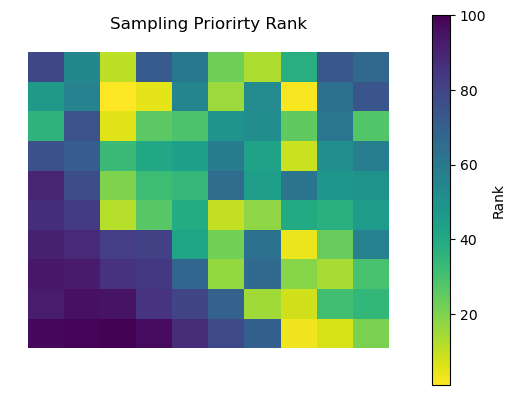

In [ ]:
gdf_grid.join(df_rank, how='left').plot(column='rank',
                                        cmap='viridis_r', 
                                        legend_kwds={'label': 'Rank'}, 
                                        legend=True)
plt.axis('off')
plt.title('Sampling Priorirty Rank');

In [ ]:
df_rank.head()

,rank
loc_id,
28,1
78,2
70,3
73,4
38,5


Based on this rank we can again: 
1. based on the **ranks (sampling priority)** and given sampling **budget**, calculate the number of samples to be collected for each administrative unit and carry out **random sampling**;
2. **perform** the random **sampling**;
3. and **carry out** the **measurements**.

#### Informed random sampling

In [ ]:
budget_t1 = 400
n = rank_to_sample(df_rank['rank'].sort_index().values, 
                   budget=budget_t1, min=1, policy="quantiles"); n

array([1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1,
       1, 1, 8, 8, 4, 8, 8, 8, 1, 1, 1, 1, 4, 4, 4, 4, 8, 3, 1, 1, 3, 4,
       4, 4, 4, 4, 3, 3, 1, 3, 8, 8, 8, 3, 3, 4, 8, 8, 3, 8, 3, 3, 8, 4,
       4, 3, 3, 8, 8, 8, 8, 8, 4, 3, 8, 8, 8, 4, 8, 4, 8, 8, 4, 4, 3, 3,
       3, 3, 8, 4, 4, 3, 4, 4, 3, 4, 3, 3])

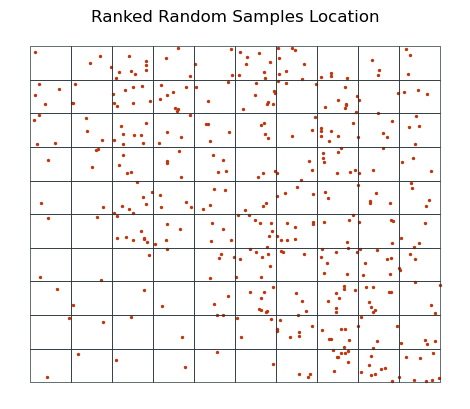

In [ ]:
sampler = Sampler(gdf_grid)
sample_locs_t1 = sampler.sample(n, method='uniform')

ax = sample_locs_t1.plot(markersize=2, color=red)
gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax)
plt.axis('off')
plt.title('Ranked Random Samples Location');

#### Second measurement campaign

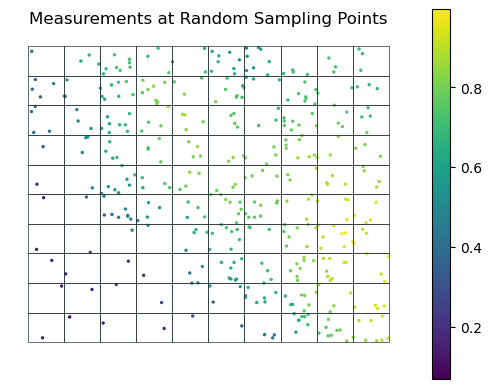

In [ ]:
dc_emulator = DataCollector(fname_raster)
measurements_t1 = dc_emulator.collect(sample_locs_t1)

ax = measurements_t1.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax);
plt.axis('off')
plt.title('Measurements at Random Sampling Points');

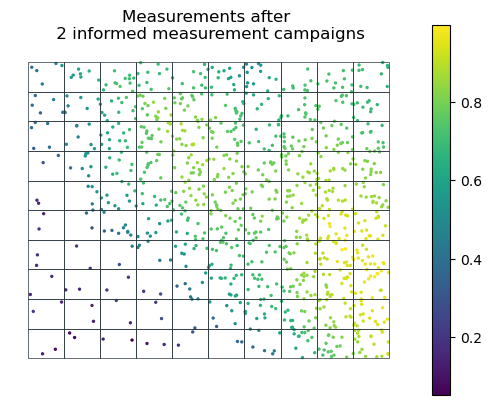

In [ ]:
measurements_sofar = pd.concat([measurements_t0, measurements_t1])

ax = measurements_sofar.plot(column='value', s=2, legend=True)
gdf_grid.boundary.plot(color=black, lw=0.5, ax=ax);
plt.axis('off')
plt.title('Measurements after \n 2 informed measurement campaigns');

## Delving deeper into the optimization process

### Determine the ranking of the administrative polygons

The **ranking** is based on the importance of increasing sampling in each polygon. A multi-criteria decision-making methodology is used to rank the polygons from most important to least important, with **lower ranks indicating a higher priority for sampling**.

#### Criteria
The state of the polygons will be used as criteria to determine the rank:

| Criteria | State variable | Criteria Type |
|----------|----------|----------|----------|
|  Estimated value    |   PriorCB()  |  Benefit  |
|  Maximum sample value  |   MaxCB()  |   Benefit  |
|  Minimal sample value  |   MinCB()  |   Benefit  |
|   Sample count  |   CountCB()  |   Cost  |
|   Standard deviation  |   StdCB()  |   Benefit  |
|   Moran I index  |   MoranICB(k=5)  |   Cost  |

#### Criteria type
Criteria can be of the type benefit or cost:

- Benefit: **high values** equal **high importance** to sample more;
- Cost: **low value** equal **high importance** to sample more).

#### Weights
A **weight vector** is used to determine the **importance of criteria** in comparison with each other.

#### MCDM techniques
- **CP** (Compromise programming):
    - Distance based measure, where the distance to the optmal point is used, where low values relate to good alternatives.
- **TOPSIS** (Technique for Order Preference by Similarity to Ideal Solution):
    - Distance-based measure, where the closeness to the optimal and anti-optimal points is assessed (with higher values indicating better alternatives).

#### Rank
Based on the MCDM value a ranking of the polygons is created:


:::{.callout-tip}

Start with using equal weights for all the criteria, later you will explore the impact of changing the weight vector. Make sure the sum of the weight vector is 1.

:::

Ranking of administrative units based on three criteria:

In [ ]:
benefit_criteria = [True, True, True]
state = State(samples_t0, gdf_grid, cbs=[MaxCB(), MinCB(), StdCB()])
weight_vector = [0.3, 0.3, 0.4]

optimizer = Optimizer(state=state())
df = optimizer.get_rank(is_benefit_x=benefit_criteria, w_vector = weight_vector,  
                    n_method="LINEAR1", c_method = None, w_method=None, s_method="TOPSIS")

df.head()

ValueError: The sum of the negative ideal distance and the positive ideal distance must not be equal to zero in order to use the TOPSIS method

Based on the ranking of the administrative units, an optimized sampling strategy for $t_1$ can be determined.

In [ ]:

combined_df = gdf_grid.join(df_rank, how='left')
combined_gdf = gpd.GeoDataFrame(combined_df)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cax = combined_gdf.plot(column='rank', cmap='Reds_r', legend=True, ax=ax)
samples_t0.plot(column='value', ax=ax, cmap='viridis', s=1.5, legend=True)

cbar = cax.get_figure().get_axes()[1]
cbar.invert_yaxis()

rank_legend = mlines.Line2D([], [], color='Red', marker='o', linestyle='None',
                            markersize=10, label='High Rank')
value_legend = mlines.Line2D([], [], color='Yellow', marker='o', linestyle='None',
                             markersize=10, label='High prior value')

ax.legend(handles=[rank_legend, value_legend], loc='upper left', bbox_to_anchor=(1.5, 1.25))
plt.show()


### Multi-year Adaptive sampling approach

- Sampling in year 0 will done based on the prior;
- Sampling in year t will be done based on 6 state variables:
    - [Max value, Min value, Standard deviation, sample count, Moran I, Prior value]
    - [0.2, 0.1, 0.1, 0.2, 0.2, 0.2]
- Sampling policy will be based on the point budget and the quantile in which the unit ranks:
    - 1st: 50 % of point budget
    - 2nd: 30% of point budget
    - 3th: 20% of point budget
    - 4th: no extra sample points

In [ ]:
number_of_years = 4
yearly_sample_budget = 150

In [ ]:
fig, axs = plt.subplots(1, number_of_years, figsize=(12, 8))  # Adjust figsize as needed
axs = axs.flatten()

sampler = Sampler(gdf_grid)
dc_emulator = DataCollector(fname_raster)

# Samples
samples_t_0 = gpd.GeoDataFrame(index=pd.Index([], name='loc_id'), geometry=None, data={'value': None})
samples_t = []

state = State(samples_t_0, gdf_grid, cbs=[PriorCB(fname_raster)])

# You have to call the instance
state_t0 = state()

benefit_criteria = [True]
optimizer = Optimizer(state=state_t0)
df_rank = optimizer.get_rank(is_benefit_x=benefit_criteria, w_vector = [1],  
                             n_method=None, c_method = None, 
                             w_method=None, s_method="CP")

combined_df = pd.merge(df, gdf_grid[['geometry']], left_index=True, right_index=True, how='inner')
combined_gdf = gpd.GeoDataFrame(combined_df)
combined_gdf.plot(column='rank',cmap='Reds_r', legend_kwds={'label': 'Rank'}, ax = axs[0])

for fig_n, ax in zip(range(1, number_of_years+1), axs[1:]):
    n = rank_to_sample(combined_gdf['rank'].sort_index().values, 
                    budget=yearly_sample_budget, min=1, policy="quantiles")
    sample_locs_t = sampler.sample(n, method='uniform')
    samples = dc_emulator.collect(sample_locs_t)
    try:
        samples_t = pd.concat([samples_t, samples])
    except:
        samples_t = pd.concat([samples])
    
    # plot points versus rank of polygon
    ax = combined_gdf.plot(column='rank', cmap='Reds_r', ax=ax)
    samples_t.plot(column='value', ax=ax, cmap='viridis', s=1)
    ax.title.set_text(f"Year {fig_n} (number of samples: {len(samples_t)})")
    
    # new state
    state = State(samples_t, gdf_grid, cbs=[
        MaxCB(), MinCB(), StdCB(), CountCB(), MoranICB(k=5), PriorCB(fname_raster)])
    
    optimizer = Optimizer(state=state())

    # 2. rank polygons
    benefit_criteria = [True, True, True, False, False, True]
    df = optimizer.get_rank(is_benefit_x=benefit_criteria, w_vector = [0.2, 0.1, 0.1, 0.2, 0.2, 0.2],  n_method="LINEAR1", c_method = None, w_method=None, s_method="CP")

    # 3. map ranking
    combined_df = pd.merge(df, gdf_grid[['geometry']], left_index=True, right_index=True, how='inner')
    combined_gdf = gpd.GeoDataFrame(combined_df)

plt.tight_layout()
plt.show()